In [1]:
##################################################
# Execute this cell and start the tutorial below #
##################################################

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# for the math
import numpy as np
from sklearn.decomposition import PCA

def create_dataset(n, p, q, σ=0.0, rank_B=None):
    
    # make sure we get the same dataset every time
    np.random.seed(31415)
    
    # if no rank was given, create a full-rank B
    if rank_B is None:
        rank_B = min(p, q)
    
    # create a random B with given rank: B = UV, with
    #   U pxr random matrix (full rank)
    #   V rxq random matrix (full rank)
    U = np.random.normal(size=(p, rank_B))
    V = np.random.normal(size=(rank_B, q))
    B = U@V
    assert(np.linalg.matrix_rank(B) == rank_B)
    
    # create random X
    X = np.random.normal(size=(n, p))
    
    # compute Y = XB
    Y = X@B
    
    # add measurement noise
    if σ > 0:
        X += np.random.normal(scale=σ, size=X.shape)
        Y += np.random.normal(scale=σ, size=Y.shape)

    return X, Y, B

def scatter_plots(datasets, titles, **kwargs):
    n = len(datasets)
    fig, axises = plt.subplots(nrows=1, ncols=n, figsize=(20, 20/n))
    for axis, data, title in zip(axises, datasets, titles):
        colors = np.arange(data.shape[0])
        axis.scatter(data[:,0], data[:,1], c=colors, alpha=0.6, cmap='viridis', **kwargs)
        axis.set_title(title)

def plot_validation_losses(n, p, q, σ, rank_B=None):
    
    # create dataset
    X, Y, B = create_dataset(n=n, p=p, q=q, σ=σ, rank_B=rank_B)
    
    rrr_ranks = list(range(9, min(100, p, q) + 1))
    error_ols_t, error_ols_v = evaluate(X, Y, B, solve_ols)
    errors_rrr = np.array([evaluate(X, Y, B, solve_rrr, rank=rank) for rank in rrr_ranks])
    errors_rrr_t = errors_rrr[:, 0]
    errors_rrr_v = errors_rrr[:, 1]

    fig, axises = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2))
    axises[0].plot(rrr_ranks, [error_ols_t]*len(rrr_ranks), label="OLS train", color='blue')
    axises[1].plot(rrr_ranks, [error_ols_v]*len(rrr_ranks), label="OLS validate", color='blue')
    axises[0].plot(rrr_ranks, errors_rrr_t, label="RRR train", color='orange')
    axises[1].plot(rrr_ranks, errors_rrr_v, label="RRR validate", color='orange')
    axises[0].set_xlabel("rank of RRR")
    axises[1].set_xlabel("rank of RRR")
    axises[0].set_ylabel("training loss")
    axises[1].set_ylabel("validation loss")
    axises[0].legend()
    axises[1].legend()

# A Gentle Introduction to Reduced Rank Regression

## Preliminaries

<center><img width="25%" src="img/intro_z_x.png"></img></center>

$X \in \mathbb{R}^{n\times p}\;\ldots$ noisy observed data ($n$ samples, $p$ features)

$Z \in \mathbb{R}^{n\times r}\;\ldots$ unknown latent structure ($r$ latent dimensions)

We assume that $r < p$. What can we learn about $Z$ if we only observe $X$?

Find latent structure through dimensionality reduction:

<div class="alert alert-block alert-success">
    <b>Linear analysis:</b>
     PCA, ICA, ...
</div>

<div class="alert alert-block alert-warning">
    <b>Non-linear methods:</b>
    t-SNE, autoencoders, ...
</div>

## Regression Problems

<center><img width="25%" src="img/intro_z_x_y.png"></img></center>

$X \in \mathbb{R}^{n\times p}\;\ldots$ noisy observed predictors ($n$ samples, $p$ features)

$Y \in \mathbb{R}^{n\times q}\;\ldots$ noisy observed responses ($q$ features)

$Z \in \mathbb{R}^{n\times r}\;\ldots$ unknown latent structure ($r$ latent dimensions)

What can we learn about the relationship between $X$ and $Y$?

<div class="alert alert-block alert-success">
    <b>Linear Multivariate Regression:</b>
    $Y=XB + \epsilon$<br/>
    with $B \in \mathbb{R}^{p\times q}$ (coefficent matrix)<br/>
    and $\epsilon \in \mathbb{R}^{n\times q},\;\epsilon_i \sim \mathcal{N}(0, \sigma_\epsilon)$ (error matrix)
</div>

## Ordinary Least Squares (OLS)

Find $B$ by minimizing difference between $Y$ and $XB$:
<center>$\hat{B}_{\text{OLS}} = \arg \min_{B} || Y - XB ||^2$</center>

<center>$
\begin{align*}
\frac{\partial}{\partial B} || Y - XB ||^2 &= 0 \\
2 (Y - XB)^T X &= 0 \\
X^T (Y - XB) &= 0 \\
X^T Y - X^TXB &= 0 \\
X^TXB &= X^T Y\;\;\;\;\;| (X^T X)^{-1} \cdot \\
B &= (X^TX)^{-1} X^T Y \\
\end{align*}
$</center>

## Implementation in numpy:
<br/>
<br/>
<center>$B = (X^TX)^{-1} X^T Y$</center>

In [211]:
# Find B* = argmin_B |Y - XB|²
def solve_ols(X, Y):
    return np.linalg.pinv(X.T@X)@X.T@Y

<div class="alert alert-block alert-warning">
    <b>Note:</b>
    Don't use numpy.linalg.inv()!
    See <a href="https://stackoverflow.com/questions/49357417/why-is-numpy-linalg-pinv-preferred-over-numpy-linalg-inv-for-creating-invers#49364727">this stackoverflow</a> answer for some details.
</div>

|B - B_ols|²: 3.0847422370805075e-15


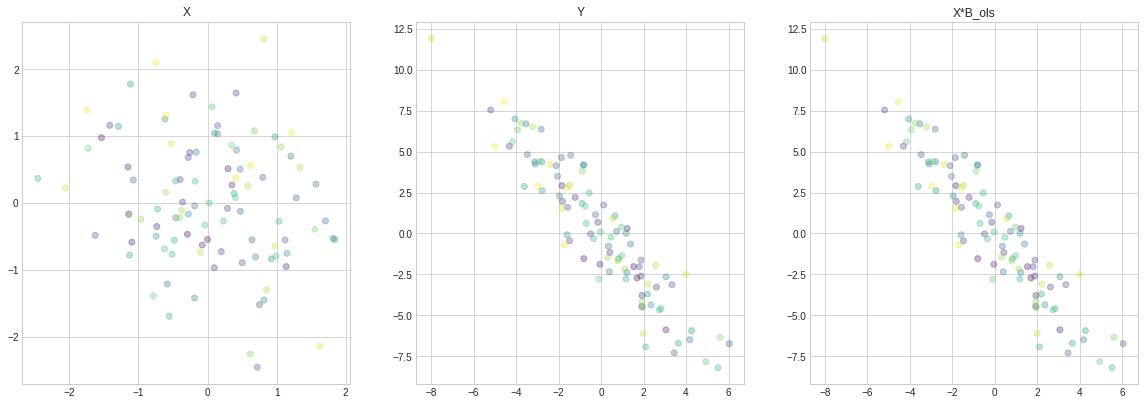

In [178]:
# create a random dataset with known B (noise free):
X, Y, B = create_dataset(n=100, p=2, q=2)

# find B_ols
B_ols = solve_ols(X, Y)

# plot X, Y, and XB
scatter_plots([X, Y, X@B_ols], ["X", "Y", "X*B_ols"])

print(f"|B - B_ols|²: {np.linalg.norm(B - B_ols)}")

## Are we done already?

There are potential problems with OLS:
1. Blind to multivariate aspect of problem: $y_i$ might be correlated, effective dimensionality smaller than $q$ 
2. Unsuitable if $p,q > n$: regularization needed

<div class="alert alert-block alert-info"><b>Try yourself:</b> Change $p$ and $q$ in the following cell to values larger than $n$, and observe how the prediction performance suffers:</div>

|B - B_ols|²: 9.155133597044475e-16


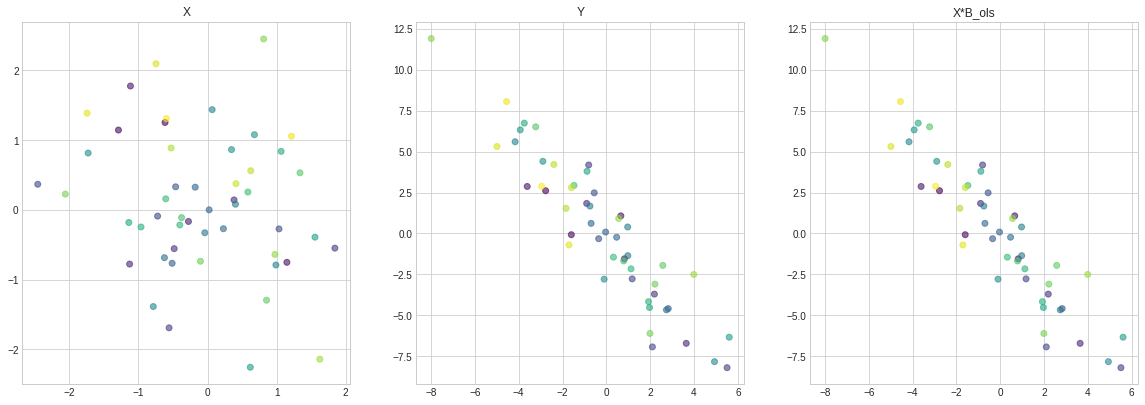

In [243]:
# create a random dataset with known B:
X, Y, B = create_dataset(n=100, p=2, q=2) # increase p and q

# find B_ols using half of the dataset
B_ols = solve_ols(X[:50], Y[:50])

# plot X, Y, and the prediction XB on the second half of the dataset
scatter_plots([X[50:], Y[50:], X[50:]@B_ols], ["X", "Y", "X*B_ols"])

print(f"|B - B_ols|²: {np.linalg.norm(B - B_ols)}")

<div class="alert alert-block alert-success"><b>Bottom line:</b> If $p, q > n$, we need to regularize $B$</div>

## X,Y Dimensionality Reduction Techniques
##  

<center>Linear Factor Regression</center>

1. PCA: Principle Component Regression
2. Project $X$ and $Y$ to common subspace: Partial Least Squares
3. Canonical Correlation Analysis

## Explicit Regularization Term on $B$
##  

<center>$\hat{B} = \arg \min_{B} || Y - XB ||^2 + R(B)$</center>

1. lasso regression: $ R(B) = \lambda_1\sum_{j=1}^p ||B_j||_1$ (least absolute shrinkage and selection operator)

2. ridge regression: $ R(B) = \lambda_2\sum_{j=1}^p ||B_j||_2$ (L2 regularizer)

3. mixture of the two: [Peng (2009)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3905690/), [Obozinski (2011)](https://projecteuclid.org/download/pdfview_1/euclid.aos/1291388368)

## Another way: Constrain the Rank of $B$
##   

<center>Reduced Rank Regression:</center>
<br/> 
<center>$\hat{B}_r = \arg \min_{B: \text{rank}(B)\leq r} ||Y - XB||^2$</center>

Termed and studied by [Izenman (1975)](https://linkinghub.elsevier.com/retrieve/pii/0047259X75900421), earlier introduced by [Anderson (1951)](https://projecteuclid.org/euclid.aoms/1177729580)

This constraint turnes the objective into a non-convex optimization problem (however, a closed form solution exists).

($\text{rank}(B)$: dimensionality of the subspace spanned by the rows or columns of $B$)

## How to Solve for $\hat{B}_r$

<br/>
<br/>
<center>$\hat{B}_r = \arg \min_{B: \text{rank}(B)\leq r} ||Y - XB||^2$</center>

Steps:
1. Decompose the loss using the OLS solution
2. Learn about the Eckart-Young-Mirsky theorem
3. Invent a potential minimizer $\hat{B}_r$ based on intuition
4. Use the Eckart-Young-Mirsky theorem to prove that it minimizes our objective

(this proof losely follows the derivation in [Mukherjee (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444519/))

### Step 1: Decompose the loss using the OLS solution

Let $\hat{B}^\text{ols} = \arg\min_B ||Y-XB||^2$ and $\hat{Y}^\text{ols} = X\hat{B}^\text{ols}$. Since the OLS solution is <a href="https://people.math.osu.edu/husen.1/teaching/571/least_squares.pdf">an orthogonal projection</a>, we can rewrite the loss as:
<br/>
<br/>
<center>
    $||Y-XB||^2 = ||Y - \hat{Y}^\text{ols}||^2 + ||\hat{Y}^\text{ols} - XB||^2$
</center>

<center>
<img src="img/orthogonal.png"></img>
</center>
<center>
(image from <a href="https://textbooks.math.gatech.edu/ila/projections.html">this tutorial</a> on orthogonal projections)
</center>

Since the first term does not depend on $B$, we can find
<center>$
    \begin{align}
        \hat{B}_r = \arg\min_{B: \text{rank}(B)\leq r} ||\hat{Y}^\text{ols} - XB||^2
                  = \arg\min_{B: \text{rank}(B)\leq r} ||X\hat{B}^\text{ols} - XB||^2\\
    \end{align}
$</center>


### Step 2: Learn about the Eckart-Young-Mirsky theorem

Let the singular value decomposition of a matrix $A = U\Sigma V^T$, with $\Sigma=\text{diag}(\pmb{\sigma})$ and $U, V$ orthogonal matrices. We will refer to the ith column of $U$ and $V$ as $\pmb{u}_i$ and $\pmb{v}_i$.

<center>$
    \begin{align}
        \arg\min_{A_r: \text{rank}(A_r)\leq r} ||A - A_r||^2 = \sum_{i=1}^r \pmb{\sigma}_i \pmb{u}_i \pmb{v}_i^T
    \end{align}
$</center>

(for a proof see, e.g., the [Wikipedia](https://en.wikipedia.org/wiki/Low-rank_approximation#Proof_of_Eckart%E2%80%93Young%E2%80%93Mirsky_theorem_(for_Frobenius_norm)) page)

### Step 3: Invent a potential minimizer

Let the singular value decomposition of $\hat{Y}^\text{ols} = U\Sigma V$ (with $\pmb{\sigma}_i$, $\pmb{u}_i$, and $\pmb{v}_i$ as defined before).

We invent a projection matrix $P_r := \sum_{i=1}^r \pmb{v}_i\pmb{v}_i^T$, i.e., the outer product of the first $r$ right hand singular vectors of $\hat{Y}^\text{ols}$.

We use this projection to construct a rank-reduced $\hat{B}_r := \hat{B}^\text{ols} P_r$.

### Step 4: Prove that $\hat{B}_r$ minimizes the loss

Recall:
1. Our loss is $||\hat{Y}^\text{ols} - XB||^2$
2. We know that $||\hat{Y}^\text{ols} - \hat{Y}^\text{ols}_r||^2$ is minimized with $\hat{Y}^\text{ols}_r = \sum_{i=1}^r \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T$ of given rank $r$
3. We constructed $\hat{B}_r := \hat{B}^\text{ols} P_r$

We need to show that $X\hat{B}_r = \hat{Y}^\text{ols}_r$:

<center>$
    \begin{align}
        X\hat{B}_r &= X\hat{B}^\text{ols}P_r
                   = \hat{Y}^\text{ols}P_r \\
                   &= \left( \sum_{i=1}^q \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T \right)
                      \left( \sum_{i=1}^r \pmb{v}_i\pmb{v}_i^T \right)
                   = \sum_{i=1}^r \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T \;\;\;\text{(see sub-slide)} \\
                   &= \hat{Y}^\text{ols}_r
    \end{align}
$</center>

Why does the following equality hold?
<center>$
\left( \sum_{i=1}^q \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T \right) \left( \sum_{i=1}^r \pmb{v}_i\pmb{v}_i^T \right)
                   = \sum_{i=1}^r \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T
$</center>

Column vectors of $V$ are orthogonal:
<center>$
\begin{align}
    \left( \sum_{i=1}^q \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T \right) \left( \sum_{i=1}^r \pmb{v}_i\pmb{v}_i^T \right)
        &= \sum_{i=1}^q \pmb{\sigma}_i\left( \sum_{j=1}^r (\pmb{u}_i\pmb{v}_i^T)(\pmb{v}_j\pmb{v}_j^T) \right) \\
        &= \sum_{i=1}^q \pmb{\sigma}_i\left( \sum_{j=1}^r (\pmb{v}_j^T\pmb{v}_i)(\pmb{u}_i\pmb{v}_j^T) \right) \\
        &= \sum_{i=1}^r \pmb{\sigma}_i\pmb{u}_i\pmb{v}_i^T \\
\end{align}
$</center>

## Implementation in numpy:

<center>$\hat{B}_r = \arg\min_{B: \text{rank}(B)\leq r} ||\hat{Y}^\text{ols} - XB||^2 = \hat{B}^\text{ols} \left( \sum_{i=1}^r \pmb{v}_i\pmb{v}_i^T \right)$</center>

In [148]:
def solve_rrr(X, Y, rank):
    
    # get OLS solution
    B_ols = solve_ols(X, Y)
    
    # get OLS estimate
    Y_ols = X@B_ols
    
    # get singular values and vectors of Y_ols
    U, Σ, V = np.linalg.svd(Y_ols)
    
    # construct P_r
    P_r = np.sum([np.outer(V[i], V[i]) for i in range(rank)], axis=0)
    
    return B_ols@P_r

<div class="alert alert-block alert-info"><b>Try yourself:</b> Change $\text{rank}$ in the following cell to 1 and see how the prediction changes:</div>

|B - B_rrr|²: 8.881784197001252e-16


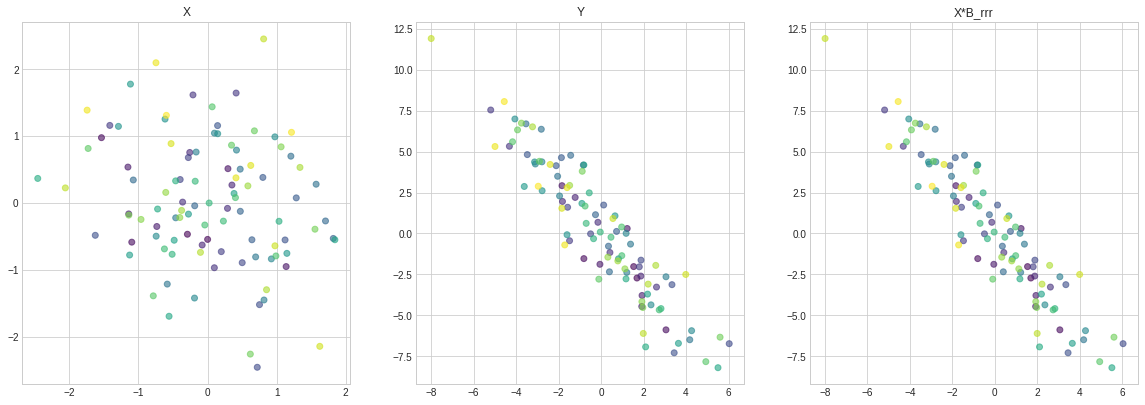

In [244]:
# create a random dataset with known B:
X, Y, B = create_dataset(n=100, p=2, q=2)

# find B_rrr
B_rrr = solve_rrr(X, Y, rank=2)

# plot X, Y, and XB
scatter_plots([X, Y, X@B_rrr], ["X", "Y", "X*B_rrr"])

print(f"|B - B_rrr|²: {np.linalg.norm(B - B_rrr)}")

In [208]:
def evaluate(X, Y, B, method, **method_kwargs):
    
    n = X.shape[0]
    
    # split into training and validation
    n_train = int(0.5*n)
    assert n_train < n
    n_valid = n - n_train
    
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_valid, Y_valid = X[n_train:], Y[n_train:]
    
    # find B by fitting to the training data
    B_estimate = method(X_train, Y_train, **method_kwargs)
    
    # compute train and validation error
    train_error = np.linalg.norm(Y_train - X_train@B_estimate)/n_train
    valid_error = np.linalg.norm(Y_valid - X_valid@B_estimate)/n_valid
    
    return train_error, valid_error

<div class="alert alert-block alert-info"><b>Try yourself:</b> Reduce the true rank $\text{rank_B}$ in the following cell and see how the validation performance changes:</div>

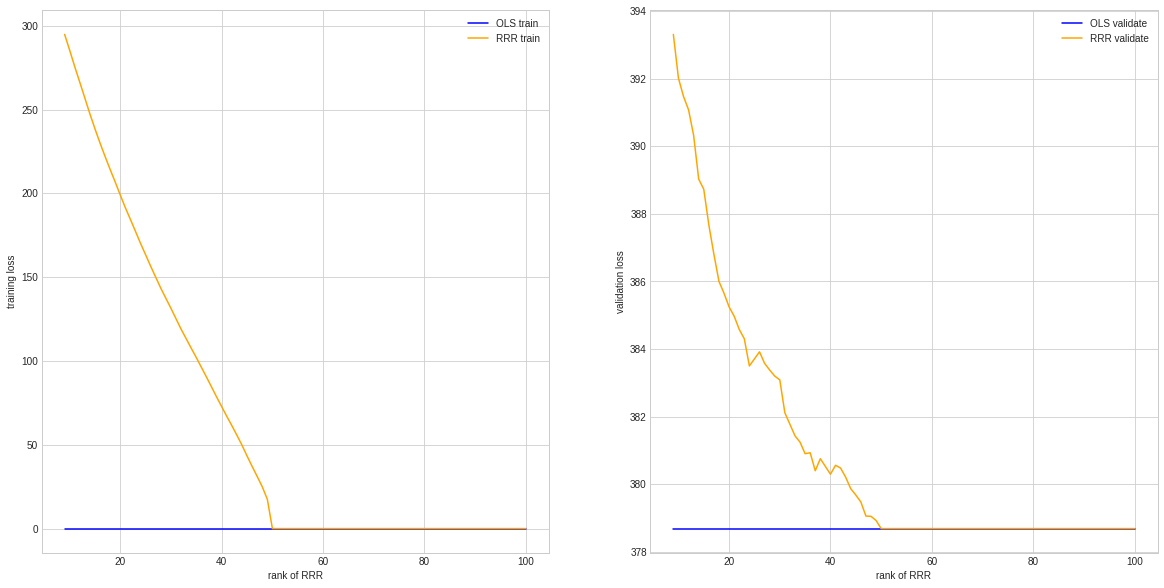

In [259]:
plot_validation_losses(n=100, p=200, q=200, σ=0.5, rank_B=200) # try rand_B=5

## More Recent Methods

1. [Reduced Rank Ridge Regression (RRRR)](https://github.com/rockNroll87q/RRRR/blob/master/reduced_rank_regressor.py) [Mukherjee (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444519/) (combination of ridge loss and reduced rank regression)
2. [Sparse Reduced-Rank Regression (sRRR)](https://github.com/berenslab/patch-seq-rrr) [Kobak (2019)](https://www.biorxiv.org/content/10.1101/302208v2) (combination of lasso and ridge loss and reduced rank regression)

![](img/sRRR_poster.png)

![](img/sRRR_overview.png)

## sRRR Objective

![](img/sRRR_objective.png)

Reduced-Rank Regression with lasso and ridge penalty. $\alpha$ trades off between the two ($\alpha=0$ = pure ridge, $\alpha=1$ = pure lasso).

## Results on Patch-Seq Datasets

![](img/sRRR_results.png)

## Error Metric

![](img/sRRR_error_metric.png)

## Interpretation of Results

![](img/sRRR_interpretation.png)

Plots based on PCA1/2 of $XW$ (left, selected genes) and $YV$ (right, electrophysiological properties).

![](img/transfer_RRR_poster.png)
![](img/transfer_RRR_overview.png)

[Svanera (2019)](https://www.biorxiv.org/content/10.1101/535377v2)

## Conlusions

* Reducing the rank is a way of regularization (but not the only one)
* On its own doesn't seem too impressive
* Methods get generally better with more paramters and validation (not so surprising...)

Should you use RRR?
* Depends on the assumptions: linear, rank-reduced relation between $X$ and $Y$